In [7]:
import kagglehub
import pandas as pd
import os

# Tải dataset và lấy đường dẫn
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
print("Path to dataset files:", path)

# Tìm tệp CSV
for file in os.listdir(path):
    if file.endswith('.csv'):
        csv_path = os.path.join(path, file)
        break
else:
    print("Không tìm thấy tệp CSV trong thư mục.")
    exit()

# Đọc dữ liệu
data = pd.read_csv(csv_path)

# Bước 1: Xóa cột không cần thiết ('id' và 'Unnamed: 32')
columns_to_drop = ['id', 'Unnamed: 32']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns], errors='ignore')
print("\nĐã xóa các cột không cần thiết (nếu có):", columns_to_drop)

# Bước 2: Kiểm tra và xóa giá trị trùng lặp
duplicates = data.duplicated().sum()
if duplicates > 0:
    data = data.drop_duplicates()
    print(f"Đã xóa {duplicates} hàng trùng lặp.")
else:
    print("Không có hàng trùng lặp.")

# Bước 3: Kiểm tra và xử lý giá trị thiếu
missing_values = data.isnull().sum().sum()
if missing_values > 0:
    data = data.dropna()
    print(f"Đã xóa các hàng chứa giá trị thiếu ({missing_values} giá trị).")
else:
    print("Không có giá trị thiếu.")

# Bước 4: Mã hóa cột 'diagnosis' (M = 1, B = 0)
if 'diagnosis' in data.columns:
    data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
    print("Đã mã hóa cột 'diagnosis' thành 0 (B) và 1 (M).")

# Kiểm tra dữ liệu sau khi làm sạch
print("\nThông tin dataset sau khi làm sạch:")
print(data.info())
print("\n5 dòng đầu tiên:")
print(data.head())

# Lưu dataset sạch
data.to_csv('breast_cancer_cleaned.csv', index=False)
print("\nĐã lưu dataset sạch vào 'breast_cancer_cleaned.csv'.")

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2

Đã xóa các cột không cần thiết (nếu có): ['id', 'Unnamed: 32']
Không có hàng trùng lặp.
Không có giá trị thiếu.
Đã mã hóa cột 'diagnosis' thành 0 (B) và 1 (M).

Thông tin dataset sau khi làm sạch:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    f

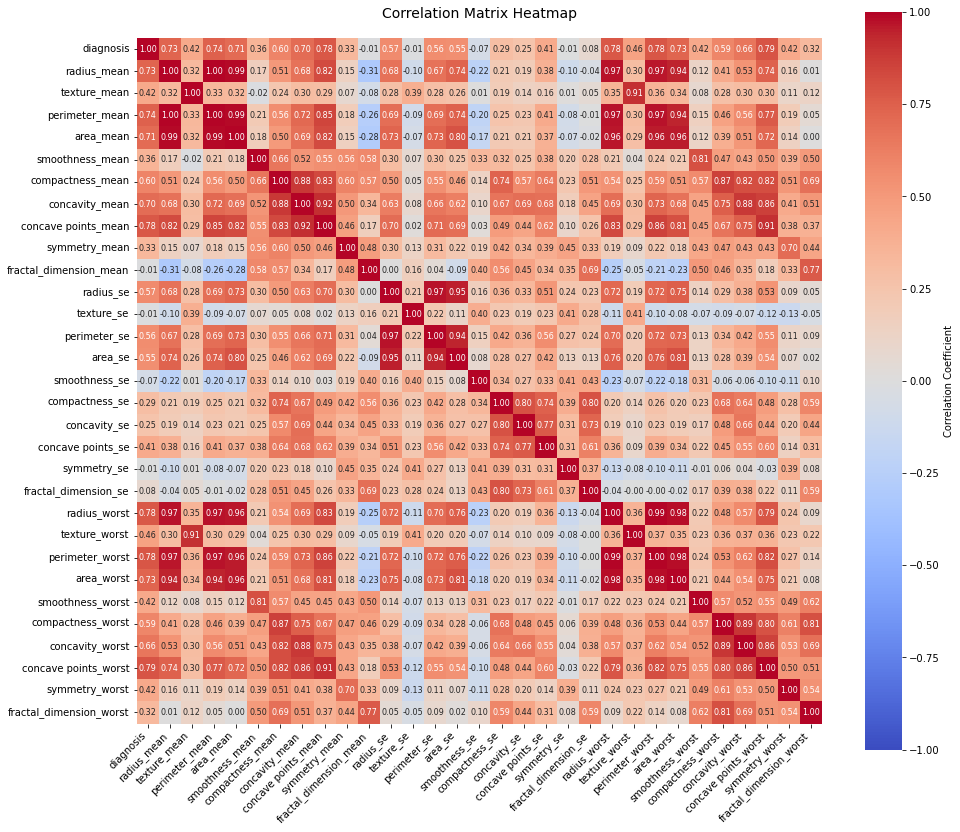

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tính ma trận tương quan
correlation_matrix = data.corr()

# Tạo figure với kích thước lớn hơn
plt.figure(figsize=(14, 12))

# Vẽ heatmap với các điều chỉnh
sns.heatmap(
    correlation_matrix,
    annot=True,              # Hiển thị giá trị tương quan
    cmap='coolwarm',        # Giữ màu coolwarm
    fmt=".2f",              # Định dạng số thập phân (2 chữ số)
    annot_kws={"size": 8},  # Tăng kích thước font chữ của giá trị tương quan
    cbar_kws={'label': 'Correlation Coefficient'},  # Thêm nhãn cho thanh màu
    square=True,            # Đảm bảo các ô là hình vuông
    vmin=-1, vmax=1         # Đặt phạm vi giá trị từ -1 đến 1 để màu sắc rõ ràng
)

# Điều chỉnh nhãn trên trục
plt.xticks(rotation=45, ha='right', fontsize=10)  # Xoay nhãn trục x 45 độ, căn phải
plt.yticks(rotation=0, fontsize=10)               # Nhãn trục y giữ ngang, tăng font chữ

# Thêm tiêu đề
plt.title("Correlation Matrix Heatmap", fontsize=14, pad=20)

# Điều chỉnh layout để tránh chồng lấn
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Chọn đặc trưng
selected_features = ['radius_mean', 'concave points_mean', 'concavity_mean', 
                    'concave points_worst', 'radius_worst', 'area_worst']
X = data[selected_features]
y = data['diagnosis']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Huấn luyện WKNN
wknn = KNeighborsClassifier(n_neighbors=5, weights='distance')
wknn.fit(X_train, y_train)

# Đánh giá bằng kiểm định chéo
scores = cross_val_score(wknn, X_scaled, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Dự đoán trên tập kiểm tra
y_pred = wknn.predict(X_test)

# Đánh giá kết quả dự đoán
print("\nĐánh giá trên tập kiểm tra:")
# Độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy trên tập kiểm tra: {accuracy:.4f}")

# Báo cáo phân loại
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=['B (Lành tính)', 'M (Ác tính)']))

Cross-validation accuracy: 0.9438 ± 0.0239

Đánh giá trên tập kiểm tra:
Accuracy trên tập kiểm tra: 0.9649

Báo cáo phân loại:
               precision    recall  f1-score   support

B (Lành tính)       0.97      0.97      0.97        71
  M (Ác tính)       0.95      0.95      0.95        43

     accuracy                           0.96       114
    macro avg       0.96      0.96      0.96       114
 weighted avg       0.96      0.96      0.96       114

